## We select from the dataset only the position on each 10th timestep
## We choose a window of 18 time steps
## We want to learn 14 steps and predict 4 steps.
## Each step = 10 seconds

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence, split_sequence_long


%load_ext autoreload
%autoreload 2

2024-04-23 10:39:05.578539: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 10:39:05.607419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 10:39:05.607442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 10:39:05.608205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 10:39:05.612630: I tensorflow/core/platform/cpu_feature_guar

### Data Exploration

In [2]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [3]:
# show head
print(data.shape)
data.head()

(4597200, 6)


,pos.x,pos.y,pos.z,heading,velocity,weather
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2


In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

4597200


### Time

In [5]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [6]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597200 entries, 0 to 4597199
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pos.x       float64
 1   pos.y       float64
 2   pos.z       float64
 3   heading     float64
 4   velocity    float64
 5   weather     int64  
 6   Minute sin  float64
 7   Minute cos  float64
dtypes: float64(7), int64(1)
memory usage: 280.6 MB


In [8]:
data.head()

,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2,-1.792514e-08,1.000000
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2,1.045284e-01,0.994522
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2,2.079117e-01,0.978148
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2,3.090170e-01,0.951057
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2,4.067366e-01,0.913545


In [9]:
temp = data

### Sub-sampling the data

We start by sub-sampling the data from 1 second intervals to 10 seconds intervals

In [12]:
# Starting from index 10 take every 10th record.
data = data[10::10]

In [13]:
# show head
print(data.shape)
data.head()

(459719, 8)


,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos
10,-76.220856,-1.436090,0.042877,-1.651711,8.587500,2,8.660254e-01,0.5
20,-71.958855,-1.998021,0.042595,-1.702724,20.223438,2,8.660254e-01,-0.5
30,-66.829414,-2.400275,0.042382,-1.634385,16.974742,2,5.008168e-09,-1.0
40,-62.348705,-2.540402,0.042411,-1.598702,15.414865,2,-8.660254e-01,-0.5
50,-57.766743,-2.609079,0.060535,-1.583040,19.992627,2,-8.660254e-01,0.5


In [15]:
# Reduce the size of the data for good partioning 
data = data.head(459702)

### Windowing
We choose a window of 18 time steps
We want to learn 14 steps and predict 4 steps.

In [16]:
window_size = 18
grouped_data = windowing_array(data, window_size)

In [17]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

25539
18
8


### Slice and Split sequence 

In [18]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [19]:
x_train_init.shape, x_test_init.shape

((20431, 18, 8), (5108, 18, 8))

In [20]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence_long(x_train_init)

In [21]:
x_train.shape, y_train.shape

((20431, 14, 8), (20431, 4, 8))

In [22]:
x_train.shape[0], x_train.shape[1], x_train.shape[2]

(20431, 14, 8)

In [23]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [24]:
y_train.shape

(20431, 4, 2)

In [25]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence_long(x_test_init)

In [26]:
x_test.shape, y_test.shape

((5108, 14, 8), (5108, 4, 8))

In [27]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [28]:
y_test.shape

(5108, 4, 2)

### Model Configuration

In [29]:
# Define the input shape
input_shape = x_train.shape[1:]
input_shape

(14, 8)

In [30]:
# Define the output shape
outout_shape = y_train.shape[1:]
outout_shape

(4, 2)

In [31]:
# Define the output vector size
y_train_feature_nr = len(y_train[1])
output_seq_size = 2
output_features_vector=y_train_feature_nr * output_seq_size
output_features_vector

8

### Train and evaluate

In [33]:
from models.transformer import ITPF_Transformer


model = ITPF_Transformer()

In [34]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_vector=output_features_vector, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [35]:
epochs = 100
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_large_multihorizon.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
511/511 [==============================] - 14s 21ms/step - loss: 2322.7297 - mae: 32.4866 - val_loss: 1355.5626 - val_mae: 21.5635 - lr: 0.0010
Epoch 2/100
511/511 [==============================] - 11s 22ms/step - loss: 1497.6782 - mae: 25.4427 - val_loss: 1314.8243 - val_mae: 21.4542 - lr: 0.0010
Epoch 3/100
511/511 [==============================] - 11s 22ms/step - loss: 1421.7350 - mae: 24.7234 - val_loss: 1268.7316 - val_mae: 20.5842 - lr: 0.0010
Epoch 4/100
511/511 [==============================] - 11s 22ms/step - loss: 1368.6780 - mae: 24.1838 - val_loss: 1266.2010 - val_mae: 20.2928 - lr: 0.0010
Epoch 5/100
511/511 [==============================] - 11s 21ms/step - loss: 1345.5778 - mae: 23.9086 - val_loss: 1225.7102 - val_mae: 20.4346 - lr: 0.0010
Epoch 6/100
511/511 [==============================] - 11s 21ms/step - loss: 1327.2876 - mae: 23.7800 - val_loss: 1215.7070 - val_mae: 20.4742 - lr: 0.0010
Epoch 7/100
511/511 [==============================] - 11s 22ms/

In [28]:
#model.summary()

In [36]:
model = keras.models.load_model("best_model_large_multihorizon.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

160/160 [==============================] - 1s 5ms/step - loss: 202.1964 - mae: 9.9221
Test accuracy 9.922141075134277
Test loss 202.19635009765625


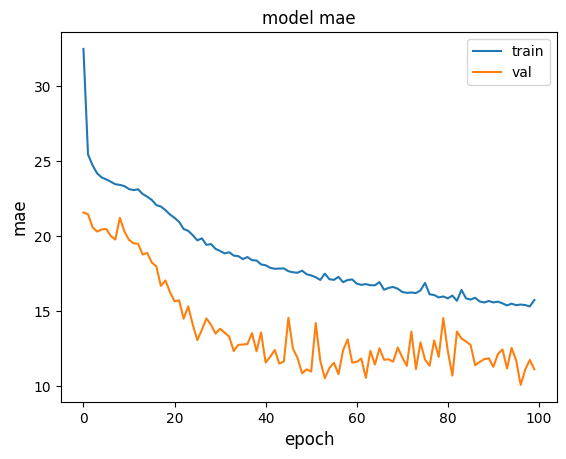

In [37]:
import matplotlib.pyplot as plt

metric = "mae"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

### Visualize the 10 best predictions

In [38]:
predictions = model.predict(x_test)

160/160 [==============================] - 1s 5ms/step


In [39]:
predictions.shape

(5108, 4, 2)

In [40]:
y_true = y_test

In [41]:

# Calculate MSE for each set of predictions
mse_values = np.mean((predictions - y_true) ** 2, axis=(1, 2))

# Find the indices of the 10 predictions with the lowest MSE
best_indices = np.argsort(mse_values)[:10]

# Select the 10 best predictions
best_predictions = predictions[best_indices]

# Retrieve the corresponding x_test entries
best_x_test = x_test[best_indices]
best_y_test = y_test[best_indices]


In [42]:
best_x_test.shape, best_predictions.shape

((10, 14, 8), (10, 4, 2))

Visualize the 10 best predictions


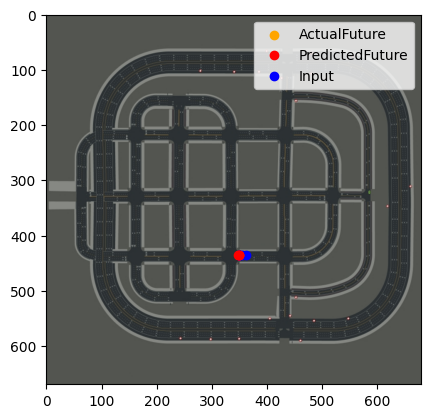

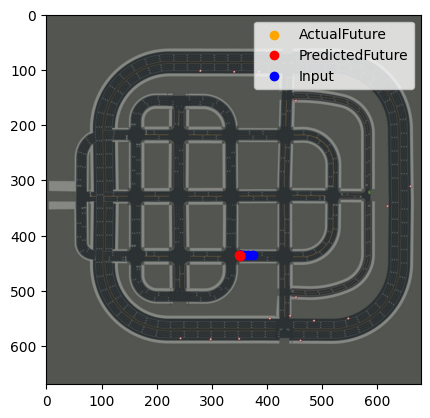

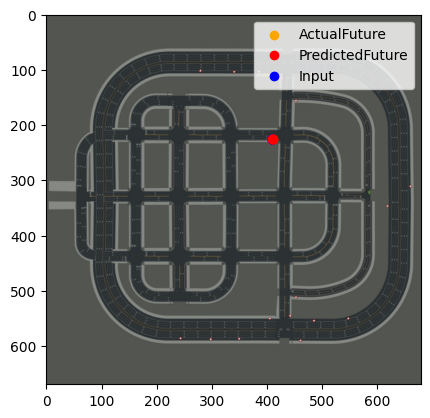

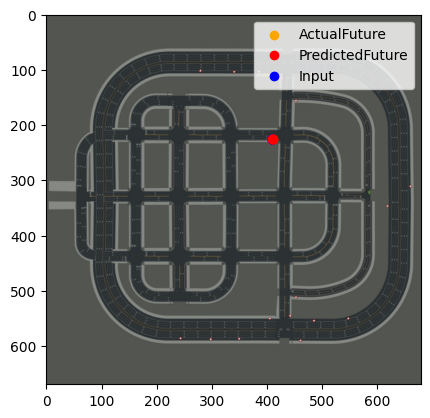

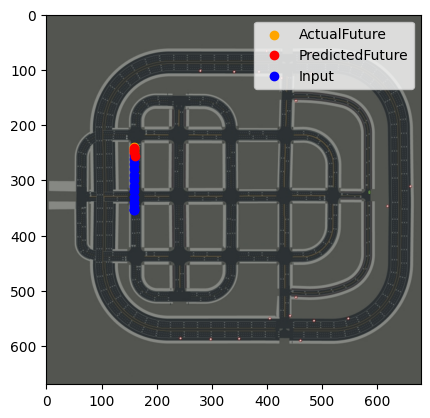

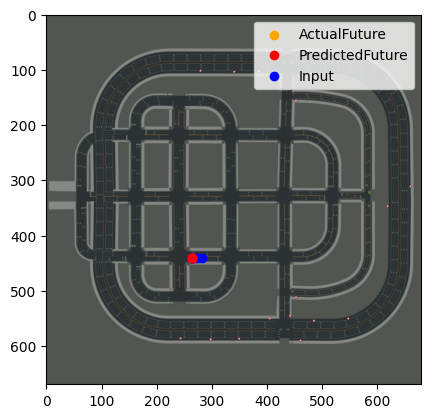

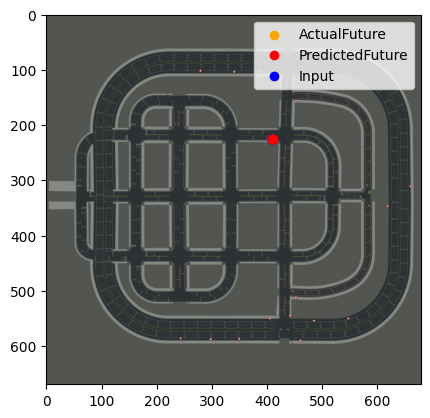

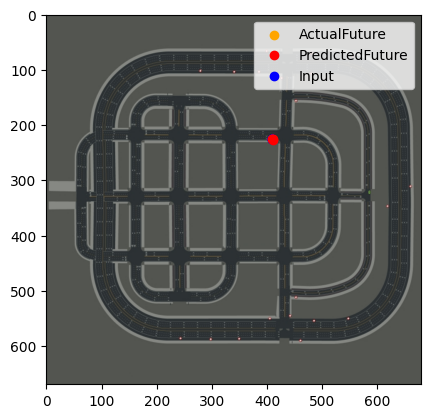

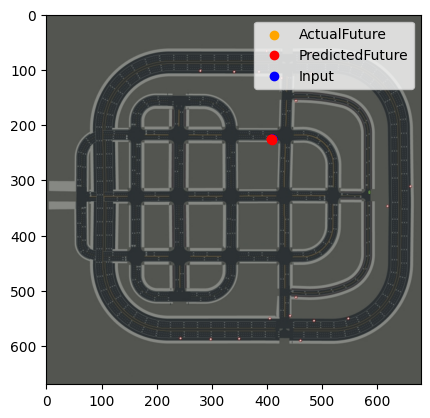

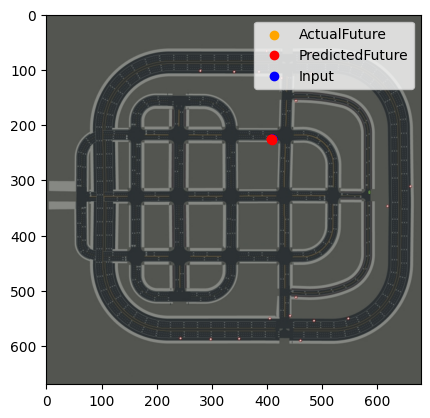

In [43]:
import random
from configs.utils_2 import plot_pred, plot_pred2


print("Visualize the 10 best predictions")

# After finding the best prediction, visualize it
if best_predictions is not None:
    for item in range(best_predictions.shape[0]):
        plot_pred2(best_x_test[:, :, :2][item], best_y_test[item], best_predictions[item])

## Explainer

In [44]:
from explainers.explainer import BlackBoxWrapper, ITPFExplainer

blackbox = BlackBoxWrapper(model=model)
explainer = ITPFExplainer()
explainer.fit_exp(
    model=blackbox, 
    x=x_train, 
    y=y_train, 
    feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"], 
    class_names=['pos.x', 'pos.y'],
    feature_nr=8,
    feature_pred_nr=2
)

In [45]:
y=best_x_test[0]

In [46]:
y.shape

(14, 8)

In [47]:
shap_values = explainer.shap_values_multivariate(y=y)

1/1 [==============================] - 0s 22ms/step


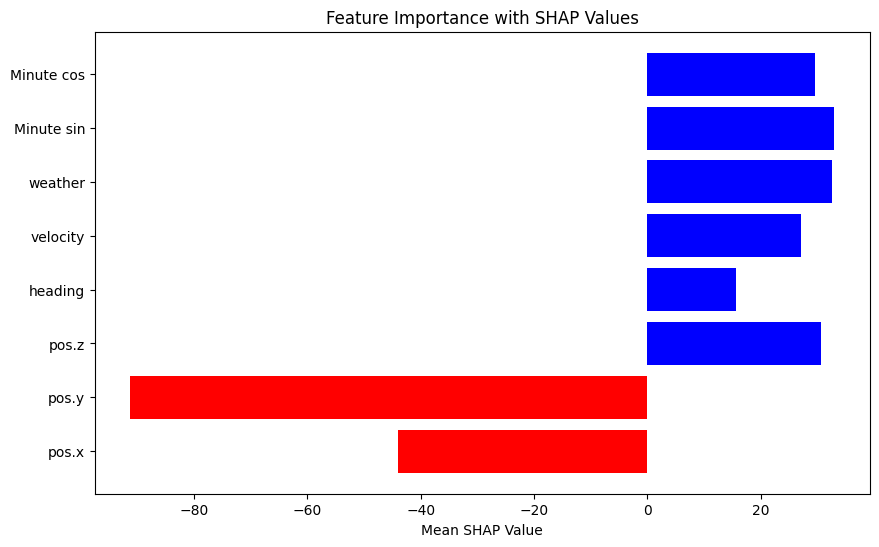

In [48]:
explainer.shap_multivariate(shap_values)